In [3]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
import matplotlib
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz
import simplekml
import cartopy
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting
from config import run_config


pd.options.mode.chained_assignment = None


#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Old

In [2]:
#base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
base_project_dir = '/Users/agmeyer4/LAIR_1/'


#SLC SOURCES
slc_sources = dict(
    landfill = {'salt_lake_valley':{'lat':40.746,'lon':-112.042},
                 'trans_jordan':{'lat':40.55862,'lon':-112.053},
                 'davis':{'lat':41.114,'lon':-111.931},
                 'weber':{'lat':41.218,'lon':-111.99},
                 'bountiful':{'lat':40.911,'lon':-111.917}},
    ww_plant = {'central_valley':{'lat':40.7036613,'lon':-111.9141398},
                 'big_cottonwood':{'lat':40.6187424,'lon':-111.7824328},
                 'se_regional':{'lat':40.5411975,'lon':-111.8191652},
                 'south_valley':{'lat':40.5033357,'lon':-111.9187493},
                 'slc':{'lat':40.8030915,'lon':-111.9295899},
                 },
    refinery = {'Chevron':        {'lat':40.825,'lon':-111.924},
                  'Big West Oil':   {'lat':40.838,'lon':-111.920},
                  'Marathon':       {'lat':40.794,'lon':-111.909},
                  'Holly Refining': {'lat':40.887,'lon':-111.904},
                  'Silver Eagle':   {'lat':40.868,'lon':-111.910}}
    )

source_df = pd.DataFrame()
for sourcetype in slc_sources.keys():
    df = pd.DataFrame(slc_sources[sourcetype]).transpose()
    df['type'] = sourcetype
    source_df = pd.concat([source_df,df])

In [ ]:
class stilt_output_handler:
    def __init__(self,stilt_base_output_path):
        self.stilt_base_output_path = stilt_base_output_path
        self.byid_path = os.path.join(stilt_base_output_path,'by-id')
        self.id_list = os.listdir(self.byid_path)
        self.id_dicts = {key: {} for key in self.id_list}
    
    def get_id_path(self,id):
        id_path = os.path.join(self.byid_path,id)
        return id_path
    
    def id_has_nc(self,id):
        files = os.listdir(self.get_id_path(id))
        if any('foot.nc' in file for file in files): #check if the footprint is in the list of files by looking for substring
            self.id_dicts[id]['has_nc'] = True
            self.id_dicts[id]['nc_fname']= [i for i in files if 'foot.nc' in i][0] #TODO find a way to do this without the list? shouldn't be multple nc file but sloppy
        else:
            self.id_dicts[id]['has_nc'] = False
        return True
    
    def check_all_for_nc(self):
        for id in self.id_list:
            self.id_has_nc(id)
    
    def get_meta_from_fname(self,fname):
        dt_str,lon_str,lat_str,zagl_str,run_id = fname.split('_')[:-1]
        lon = float(lon_str)
        lat = float(lat_str)
        zagl = float(zagl_str)
        run_id = int(run_id)
        return {'dt_str':dt_str,'lon':lon,'lat':lat,'zagl':zagl,'run_id':run_id}

    def get_all_meta(self):
        for id in self.id_dicts.keys():
            try:
                fname = self.id_dicts[id]['nc_fname']
            except:
                continue
                
            self.id_dicts[id].update(self.get_meta_from_fname(fname))
            self.id_dicts[id]['full_nc_path'] = os.path.join(self.get_id_path(id),fname)
            self.id_dicts[id]['id']=id

In [ ]:
my_stilt_handler = stilt_output_handler(f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/STILT/20230711_stilt/out')
my_stilt_handler.check_all_for_nc()
my_stilt_handler.get_all_meta()

stilt_footprints_df = pd.DataFrame(my_stilt_handler.id_dicts).transpose()
stilt_footprints_df['dt'] = pd.to_datetime(stilt_footprints_df['dt_str']).dt.tz_localize('UTC')
stilt_footprints_df = stilt_footprints_df.set_index('dt')
stilt_footprints_df_good =stilt_footprints_df.dropna()
stilt_footprints_df_good.index = stilt_footprints_df_good.index.tz_convert('US/Mountain')
stilt_footprints_df_good = stilt_footprints_df_good.sort_values('run_id')

# em27_data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'
# tz = 'US/Mountain'
# dt_range = {'dt1':'2023-07-11 08:00:00','dt2':'2023-07-11 20:00:00'}
# oof_manage = ac.oof_manager(em27_data_folder,tz)
# em27_df = oof_manage.load_oof_df_inrange(dt_range['dt1'],dt_range['dt2'],True)
# em27_df = em27_df.resample('T').mean()
# species = 'xch4(ppm)'

In [ ]:
my_stilt_handler = stilt_output_handler(f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/STILT/20230809_stilt/out')
my_stilt_handler.check_all_for_nc()
my_stilt_handler.get_all_meta()

stilt_footprints_df = pd.DataFrame(my_stilt_handler.id_dicts).transpose()
stilt_footprints_df['dt'] = pd.to_datetime(stilt_footprints_df['dt_str']).dt.tz_localize('UTC')
stilt_footprints_df = stilt_footprints_df.set_index('dt')
stilt_footprints_df_good =stilt_footprints_df.dropna()
stilt_footprints_df_good.index = stilt_footprints_df_good.index.tz_convert('US/Mountain')
stilt_footprints_df_good = stilt_footprints_df_good.sort_values('run_id')

em27_data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'
tz = 'US/Mountain'
dt_range = {'dt1':'2023-08-09 08:00:00','dt2':'2023-08-09 20:00:00'}
oof_manage = ac.oof_manager(em27_data_folder,tz)
em27_df = oof_manage.load_oof_df_inrange(dt_range['dt1'],dt_range['dt2'],True)
em27_df = em27_df.resample('T').mean()
species = 'xch4(ppm)'

In [ ]:
save_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/oct2023/STILT/20230711/'

min_foot = 0.001
j = 0
for dt in stilt_footprints_df_good.index.unique():
    if j==0:
        j+=1
        continue
    sub_df = stilt_footprints_df_good.loc[stilt_footprints_df_good.index == dt]

    fp = sub_df.iloc[0]
    full_nc_path = fp['full_nc_path']
    ds = xr.open_dataset(full_nc_path)
    summed_da = ds.sum(dim='time')
    foot_sum = summed_da.foot

    for i in range(1,len(sub_df)):
        fp = sub_df.iloc[i]
        full_nc_path = fp['full_nc_path']
        ds = xr.open_dataset(full_nc_path)
        summed_da = ds.sum(dim='time')
        foot_da = summed_da.foot
        foot_sum = foot_sum + foot_da

    foot_sum_masked = foot_sum.where(foot_sum>min_foot)

    inst_lat = 40.766
    inst_lon = -111.847
    extent=[-112.3,-111.5,40.5,41.0]
    labsize = 14

    zoom = 0.2
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    request = cimgt.GoogleTiles(style='satellite')
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    ax.add_image(request,int(scale))
    footplot = foot_sum_masked.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint (not weighted)',size=labsize)

    colors = ['#CC3311','#0077BB','#F4BB44']
    i= 0
    for source_type in source_df.groupby('type').sum().index:
        minidf = source_df.loc[source_df['type'] ==source_type]
        ax.scatter(minidf['lon'],minidf['lat'],label=source_type,c=colors[i],s=40)
        i+=1

    ax.scatter(inst_lon,inst_lat,label='EM27',marker='x',c='k',s=70)
    t = ax.text(extent[1]-.17,extent[2]+.02,f'{dt.hour:02}:{dt.minute:02}{"MDT"}',fontsize=20,color='k')
    t.set_bbox(dict(facecolor='white', alpha=0.7))

    axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
    axins.scatter(em27_df.index,em27_df[species],color = 'blue',zorder=3,s=1)
    # axins.errorbar(em27_df.index,em27_df[species],
    #                 yerr=em27_df[f'{species}_error'],ls='none',
    #                 ecolor='grey',alpha=0.2)
    axins.tick_params(labelsize = labsize)
    axins.set_ylabel(species,size = labsize)
    axins.vlines(dt,axins.get_ylim()[0],axins.get_ylim()[1],zorder = 10,linewidth=5,color = 'grey',alpha = 0.5)
    axins.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
    axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = em27_df.index.tz))
    axins.set_xlabel(em27_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
    ax.legend(fontsize=labsize,loc = 0)
    plt.gcf().autofmt_xdate()
    plt.show()
    savename = f"{dt.hour:02}.png"
    fig.savefig(os.path.join(save_path,savename),dpi=500)
    


In [ ]:
min_foot = 0.00

for idx in range(len(stilt_footprints_df_good)):
#idx = 72
    fp = stilt_footprints_df_good.iloc[idx]
    full_nc_path = fp['full_nc_path']
    lat = fp['lat']
    lon = fp['lon']
    zagl = fp['zagl']
    dt_str = fp['dt_str']
    dt = fp.name
    id = fp.id

    inst_lat = 40.766
    inst_lon = -111.847

    ds = xr.open_dataset(full_nc_path)
    summed_da = ds.sum(dim='time')
    foot = summed_da.foot
    masked_foot = foot.where(foot>min_foot)

    extent=[-112.3,-111.5,40.5,41.0]


    species = 'xch4(ppm)'
    labsize = 14

    stilt_footprint_png_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/'
    stilt_footprint_png_fname = f'{id}.png'

    print(id)
    zoom = 0.2
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    request = cimgt.GoogleTiles(style='satellite')
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    ax.add_image(request,int(scale))
    #contour = ax.contourf(summed_da['lon'],summed_da['lat'],summed_da.foot,transform = proj , alpha = 0.9,vmin=min_foot)
    foot = masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(foot,fraction=0.033)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)

    colors = ['#CC3311','#0077BB','#F4BB44']
    i= 0
    for source_type in source_df.groupby('type').sum().index:
        minidf = source_df.loc[source_df['type'] ==source_type]
        ax.scatter(minidf['lon'],minidf['lat'],label=source_type,c=colors[i],s=40)
        i+=1

    t = ax.text(extent[1]-.2,extent[2]+.02,f'{dt.month}-{dt.day} {dt.hour}:{dt.minute:02}{"MDT"}\n{zagl}m agl',fontsize=20,color='k')
    t.set_bbox(dict(facecolor='white', alpha=0.7))

    ax.scatter(inst_lon,inst_lat,label='EM27',marker='x',c='k',s=70)

    # axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
    # axins.scatter(em27_df.index,em27_df[species],color = 'grey',zorder=3,label='True Data Rate',s=1)
    # axins.errorbar(em27_df.index,em27_df[species],
    #                 yerr=em27_df[f'{species}_error'],ls='none',
    #                 ecolor='grey',alpha=0.2)
    # axins.tick_params(labelsize = labsize)
    # axins.set_ylabel(species,size = labsize)
    # axins.vlines(dt,axins.get_ylim()[0],axins.get_ylim()[1],zorder = 10,linewidth=5)
    # axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = em27_df.index.tz))
    # axins.set_xlabel(em27_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
    # plt.gcf().autofmt_xdate()

    ax.legend(fontsize=labsize)
    plt.show()
    #fig.savefig(os.path.join(stilt_footprint_png_path,stilt_footprint_png_fname),bbox_inches='tight')

# Stilt loader with id scheme

In [23]:
config_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test/20230711/config'
config_json_fname = os.listdir(config_path)[0]
configs = run_config.run_config_obj(config_json_fname=config_json_fname) #load the configs
stilt_name = '20230711'
stilt_path = os.path.join(configs.folder_paths['stilt_folder'],stilt_name,'receptors')
stilt_rec = ac.StiltReceptors(configs,full_filepath = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/output/receptors/ground/20230711_100000_235959.csv')

In [24]:
stilt_rec.load_receptors()

In [25]:
stilt_rec.__dict__

{'configs': <config.run_config.run_config_obj at 0x1554bec02ed0>,
 'dt1': datetime.datetime(2023, 7, 11, 10, 0, tzinfo=datetime.timezone.utc),
 'dt2': datetime.datetime(2023, 7, 11, 23, 59, 59, tzinfo=datetime.timezone.utc),
 'full_filepath': '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/output/receptors/ground/20230711_100000_235959.csv',
 'inst_lat': 40.766,
 'inst_lon': -111.847,
 'inst_zasl': 1492.0,
 'dt_range_strs': ['2023-07-11 10:00:00+00:00', '2023-07-11 23:59:59+00:00'],
 'rec_df':      sim_id                 run_times     lati      long    zagl  z_is_agl  \
 0         0 2023-07-11 13:00:00+00:00  40.7660 -111.8470    51.0      True   
 1         1 2023-07-11 13:00:00+00:00  40.7717 -111.8285   106.0      True   
 2         2 2023-07-11 13:00:00+00:00  40.7774 -111.8101   326.0      True   
 3         3 2023-07-11 13:00:00+00:00  40.7830 -111.7916   375.0      True   
 4         4 2023-07-11 13:00:00+00:00  40.7887 -111.7731   352.0      True   
 ..      ...  

In [2]:
class stilt_rec_handler:
    def __init__(self,rec_csv_fullpath):
        self.rec_csv_fullpath = rec_csv_fullpath

    def full_recfile_load(self):
        self.parse_rec_header()
        self.rec_df = self.read_rec_csv()
        self.split_dfs = self.split_recdf_bytime()
        

    def parse_rec_header(self):
        '''Read the header of the receptor file and store the data in the class'''

        with open(self.rec_csv_fullpath) as f: #open the file
            header_lines = [] #initialize a list of the header lines
            line = ' ' #make line a space to get into the while loop
            while line != '': #the header should be followed by a blank line. stop after we read that
                line = f.readline().strip() #read the line and strip the newline character
                header_lines.append(line) #append the line to the header_lines list

        for line in header_lines: #loop through the header lines
            if line.split(':')[0] == 'Instrument Location': #ge the instrument location
                inst_loc_vals = line.split(':')[-1]
                self.inst_lat = float(inst_loc_vals.split(',')[0].strip(' ,'))
                self.inst_lon = float(inst_loc_vals.split(',')[1].strip(' ,'))
                self.inst_zasl = float(inst_loc_vals.split(',')[2].strip(' ,masl'))
            if line.split(':')[0] == 'Datetime range': #get the datetime range
                inst_dt_vals = line.split('Datetime range:')[-1]
                self.dt_range_strs = [inst_dt_vals.split(' to ')[0],inst_dt_vals.split(' to ')[1]]
            if line.split(':')[0] == 'Data date':
                self.data_datestr = line.split(':')[1].strip()
        
    def read_rec_csv(self):
        '''Reads the actual data in the receptor file to a pandas dataframe for later reference'''
        rec_df = pd.read_csv(self.rec_csv_fullpath,header = 6)
        rec_df['run_times'] = pd.to_datetime(rec_df['run_times'])
        return rec_df    

    def split_recdf_bytime(self):
        '''Splits the receptor dataframe into a list of dataframes, with each having the same run_time (the vertical levels for that run_time)
        
        Returns:
        split_dfs (list): list of dataframes, where each is a dataframe of a single run time representing the vertical levels
        '''
       
        split_dfs = [] #initialize the timegrouped list
        for name, group in self.rec_df.groupby('run_times'): #groupby runtime
            sub_df = group.copy() #copy to avoid overwriting
            split_dfs.append(sub_df) #append the df to the list

        return split_dfs    

# all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
# project_dir = '20230711_stilt'
# rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

# stilt_rec = stilt_rec_handler(rec_csv_fullpath)
# stilt_rec.full_recfile_load()

In [3]:
class stilt_output_handler:
    def __init__(self,project_fullpath):
        self.project_fullpath = project_fullpath
        self.out_byid_fullpath = os.path.join(project_fullpath,'out','by-id')
        self.rec_path = os.path.join(project_fullpath,'receptors')

    def load_stilt_rec(self):
        '''Create a receptor class for the given receptor CSV in the project directory
        
        Returns:
        stilt_rec (stilt_rec_handler object): stilt receptor class with metadata and df
        '''

        #Check to make sure there is only one receptor csv file in the folder
        if len(os.listdir(self.rec_path))>1:
            raise Exception(f'More than one receptor file in {self.rec_path}. Check the setup or amend this code')
        if len(os.listdir(self.rec_path))==0:
            raise Exception(f'No receptor csv files in {self.rec_path}. Check stilt setup.')
        rec_csv_name = os.listdir(self.rec_path)[0] #should only be one file in the dir, use that as the receptor file
        stilt_rec = stilt_rec_handler(os.path.join(self.rec_path,rec_csv_name)) #initialize the receptor handler
        stilt_rec.full_recfile_load() #load the receptor file and its metadata
        self.stilt_rec = stilt_rec #save it to the class

    def get_id_path(self,id):
        '''Gets the full path to the id folder given that id
        
        Args: 
        id (str): the simulation id corresponding with a folder in the "by-id" folder of the stilt out folder
        
        Returns:
        id_fullpath (str): string of the full path to the id subfolder
        '''

        id_fullpath = os.path.join(self.out_byid_fullpath,id)
        return id_fullpath

# all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
# project_dir = '20230711_stilt'
# project_fullpath = os.path.join(all_stilt_path,project_dir)
# my_stilt_output_handler = stilt_output_handler(project_fullpath)
# my_stilt_output_handler.load_stilt_rec()

In [4]:
class sing_foot_loader:
    def __init__(self,nc_fullpath):
        self.nc_fullpath = nc_fullpath
    
    def get_tsummed_ds(self):
        '''Main function to get a footprint dataset summed on time
        
        Returns:
        tsummed_df (xarray.DataSet): dataset of a single receptor footprint, summed on time
        '''
        ds = self.load_full_ds()
        tsummed_df = self.sum_on_time(ds)
        return tsummed_df

    def load_full_ds(self):
        '''Loads the full xarray dataset from an nc footprint file
        
        Returns:
        ds (xarray.DataSet): dataset containing the full footprint, as output by STILT
        '''

        ds = xr.open_dataset(self.nc_fullpath)
        return ds
    
    def sum_on_time(self,ds):
        '''Sum over the time variable of a footprint dataset
        
        Args:
        ds (xarray.DataSet): dataset containing the full footprint including a time dimension, as output by STILT when timesum is off. 

        Returns:
        sum_ds (xarray.DataSet): dataset containing the time summed footprint
        '''

        sum_ds = ds.sum(dim='time')
        return sum_ds

# all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
# project_dir = '20230711_stilt'
# rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

# stilt_rec = stilt_rec_handler(rec_csv_fullpath)
# stilt_rec.full_recfile_load()
# singtime_recdf = stilt_rec.split_dfs[0]

# i = 0

# id_str = str(singtime_recdf.iloc[i]['sim_id'])
# nc_fullpath = os.path.join(all_stilt_path,project_dir,'out','by-id',id_str,f'{id_str}_foot.nc')

# sing_foot = sing_foot_loader(nc_fullpath)
# sing_foot.get_tsummed_ds()

In [40]:
class timegrp_foot_handler:
    def __init__(self,split_rec_df,out_byid_fullpath,sim_id_dim_map):
        self.split_rec_df = split_rec_df
        self.out_byid_fullpath = out_byid_fullpath
        self.sim_id_dim_map = sim_id_dim_map
        self.check_and_add_time()

    def check_and_add_time(self):
        '''Check to make sure that the split_rec_df is only one run_time (this class meant to only accept singletimes). And add that time as an attr
        '''

        if len(self.split_rec_df.groupby('run_times'))>1:
            raise ValueError('The input split_rec_df has more than one runtime included')
        else:
            self.run_time = self.split_rec_df.iloc[0]['run_times']

    def get_full_ds(self):
        '''Retrieve all of the footprints for the receptors in the split_rec_df using sing_stiltfoot_loader
        
        Args:
        sim_id_mapdict (dict): a dictionary of form {'new_dim_name':val,'id_map':{[sim_ids]:[map_to_val]}}. 'new_dim_name' is the name of the new dimension
                                'id_map' is a dictionary where the keys are the sim_ids, and map_to_val are the values for the new dim that the sim_ids should 
                                map to, such that the new dimension will have new_dim_name and values map_to_val, corresponding to each sim_id in the dict
                                
        Returns:
        combined_ds (xarray.Dataset): an xarray dataset with three dims and coords (lat, lon, new_dim_name) and one data variable (foot)
        '''

        tsummed_foots = self.get_tsummed_foots() #get the timesummed footprint dictionary, with keys = sim_ids and values = single datasets of footprints with lat/lon dim/coords
        
        datasets = list(tsummed_foots.values()) #create a list of the datasets for concatenation
        sim_ids = list(tsummed_foots.keys()) #create a list of the sim_ids (keys of tsummed_foots) to transform the new dim/coords

        combined_ds = xr.concat(datasets,dim=self.sim_id_dim_map['new_dim_name']) #concat the dataset with the new dim

        new_dim_values = [self.sim_id_dim_map['id_map'][sim_id]for sim_id in sim_ids] #map the new dimension values based on the sim ids and the id_map from the sim_id_mapdict
        combined_ds = combined_ds.assign_coords({self.sim_id_dim_map['new_dim_name']:new_dim_values}) #associate coordinates with the new dim, using the values from the id_map

        return combined_ds
    
    def get_tsummed_foots(self):
        '''Get a dictionary of footprints for a single time group. This contains all of the data for that timegroup, in dictionary form
        
        Returns:
        tsummed_foots (dict) : a dictionary with keys = sim_id and values = a single time summed dataset for that sim_id
        '''

        tsummed_foots = {}  #initialize the dict
        for index,row in self.split_rec_df.iterrows(): #loop through the split_rec_df to find the footprints we need for this timegroup
            sim_id = row['sim_id'] #get the sim_id from the row
            nc_fullpath = os.path.join(self.out_byid_fullpath,str(sim_id),f'{sim_id}_foot.nc') #get the location of the footprint nc file
            try: #put in a try statement in case there is no nc file for that sim_id
                sing_foot = sing_foot_loader(nc_fullpath) #create the footprint loader
                ds = sing_foot.get_tsummed_ds() #get the xarray dataset for that single footprint
                tsummed_foots[sim_id] = ds #add it to the dictionary
            except FileNotFoundError: #if there is no nc file, we hit this
                tsummed_foots[sim_id] = xr.zeros_like(ds)
                #raise FileNotFoundError('No nc file for that sim_id. Need to deal with this error.')
        return tsummed_foots
    
    def create_weighting_dict(self,weight_func):
        return weight_func(self.sim_id_dim_map)
    
    def combine_and_weight(self,weight_func):
        combined_ds = self.get_full_ds()
        weighting_dict = timegrp_foot.create_weighting_dict(weight_func)
        combined_ds['foot_x_wgt'] = combined_ds['foot'] * xr.DataArray(list(weighting_dict.values()),dims=self.sim_id_dim_map['new_dim_name'])
        return combined_ds
    
    def sum_on_level(self,combined_ds):
        summed_ds = combined_ds.sum(dim=self.sim_id_dim_map['new_dim_name'])
        return summed_ds
    
class weighting_functions:
    def __init__(self):
        pass
    
    def equal_weight(sim_id_dim_map):
        dim_vals = sim_id_dim_map['id_map'].values()
        num_levels = len(sim_id_dim_map['id_map'])
        weighting_dict = {}
        for dim_val in dim_vals:
            weighting_dict[dim_val] = 1/num_levels
        return weighting_dict   
    
    def eq_to_dim(sim_id_dim_map):
        weighting_dict = {}
        for dim_val in sim_id_dim_map['id_map'].values():
            weighting_dict[dim_val] = dim_val
        return weighting_dict

all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
project_dir = '20230711_stilt'
rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

stilt_rec = stilt_rec_handler(rec_csv_fullpath)
stilt_rec.full_recfile_load()
split_rec_df = stilt_rec.split_dfs[1]

sim_id_dim_map = {'new_dim_name':'zail',
                  'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['zail']))}

out_byid_fullpath = os.path.join(all_stilt_path,project_dir,'out','by-id')
timegrp_foot = timegrp_foot_handler(split_rec_df,out_byid_fullpath,sim_id_dim_map)
combined_ds = timegrp_foot.combine_and_weight(weighting_functions.equal_weight)
summed_ds = timegrp_foot.sum_on_level(combined_ds)


In [41]:
all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
project_dir = '20230711_stilt'
rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

stilt_rec = stilt_rec_handler(rec_csv_fullpath)
stilt_rec.full_recfile_load()

summed_ds_ts = {}
for split_rec_df in stilt_rec.split_dfs:

    sim_id_dim_map = {'new_dim_name':'zail',
                    'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['zail']))}

    out_byid_fullpath = os.path.join(all_stilt_path,project_dir,'out','by-id')
    timegrp_foot = timegrp_foot_handler(split_rec_df,out_byid_fullpath,sim_id_dim_map)
    combined_ds = timegrp_foot.combine_and_weight(weighting_functions.equal_weight)
    summed_ds = timegrp_foot.sum_on_level(combined_ds)
    summed_ds_ts[timegrp_foot.run_time] = summed_ds

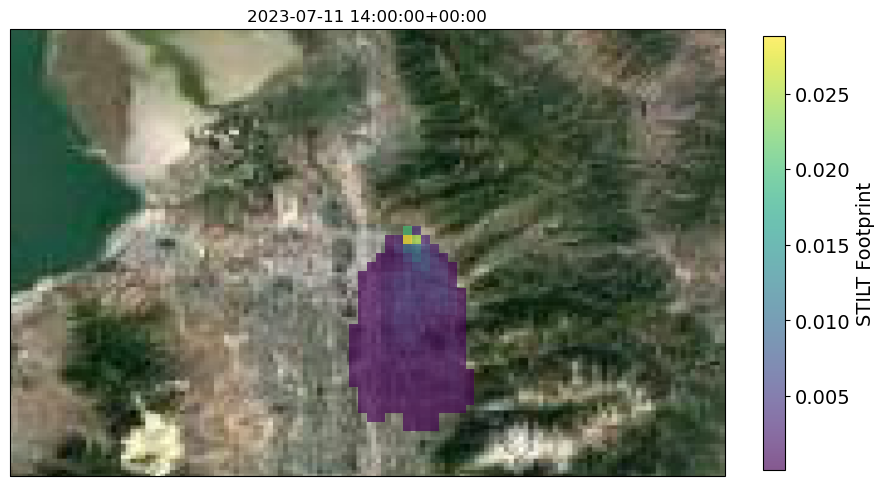

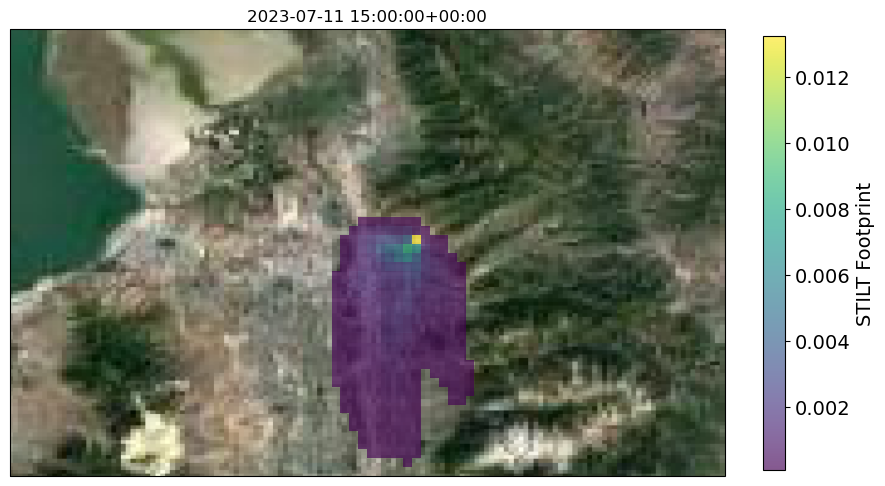

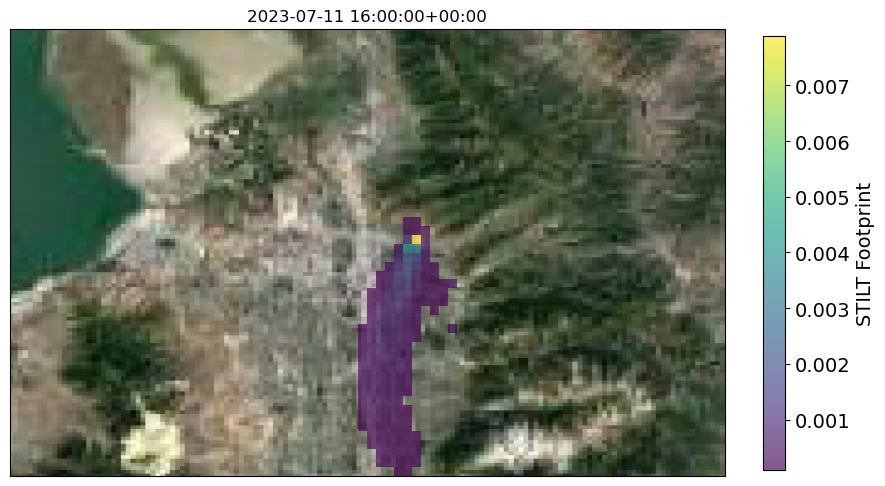

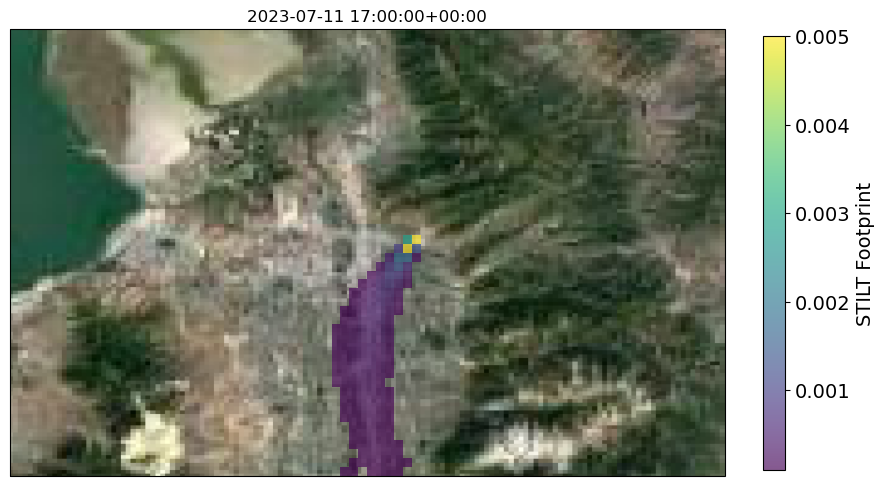

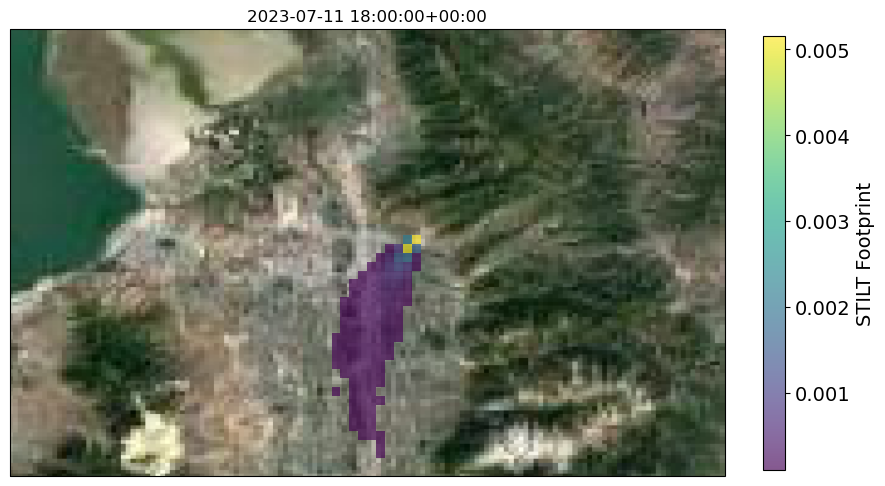

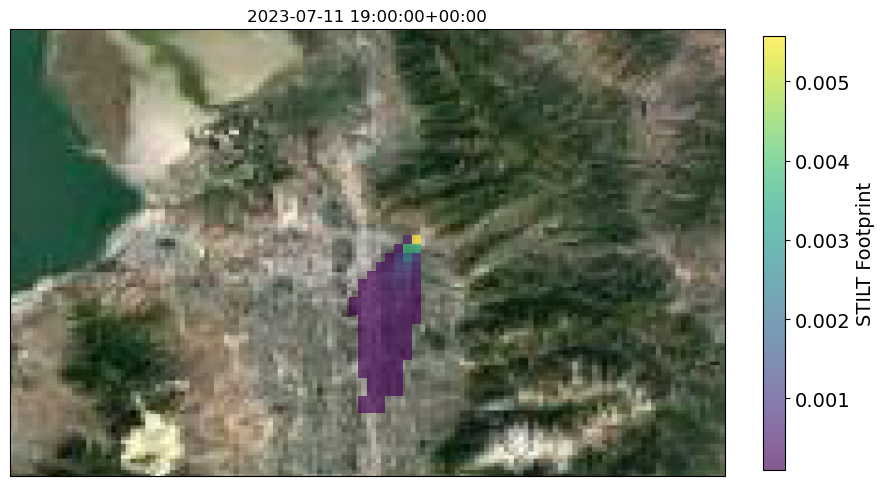

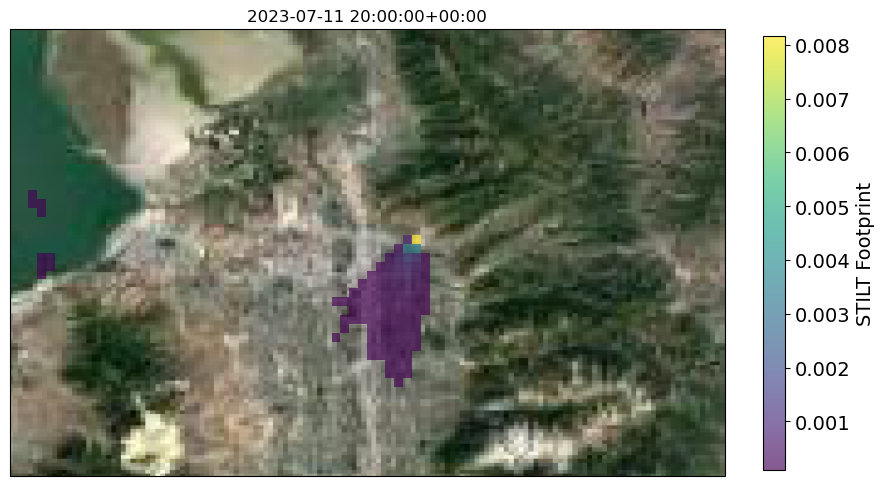

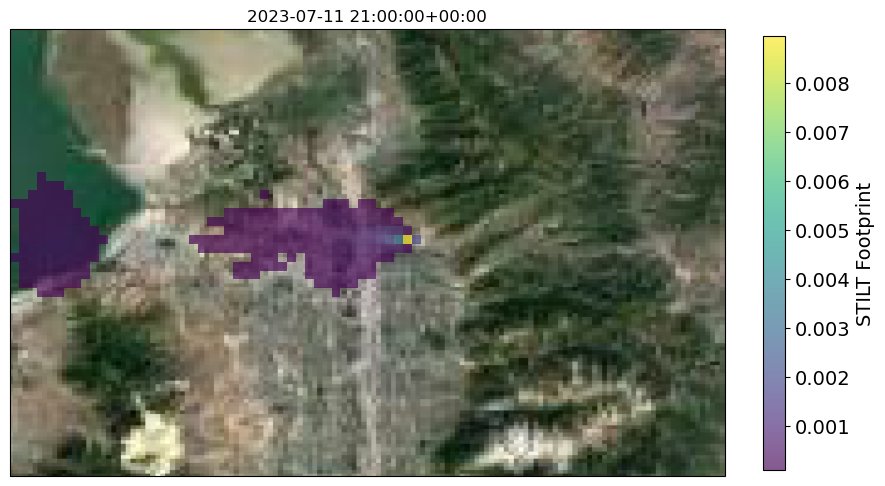

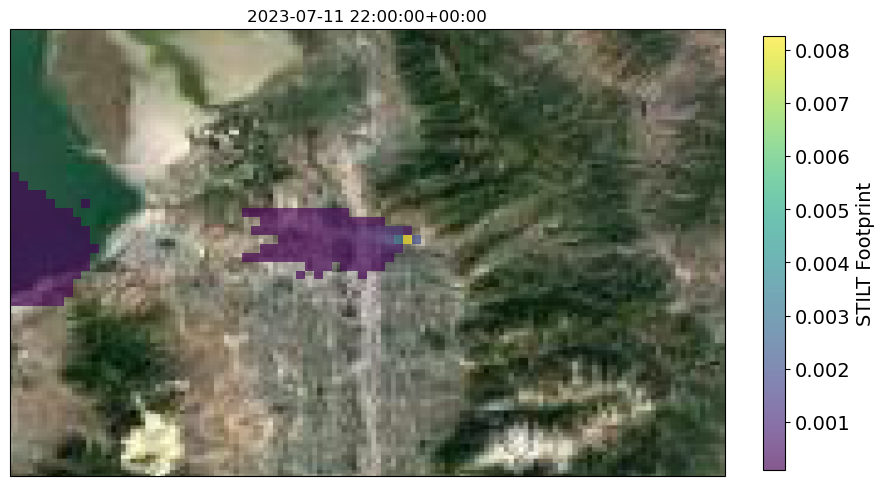

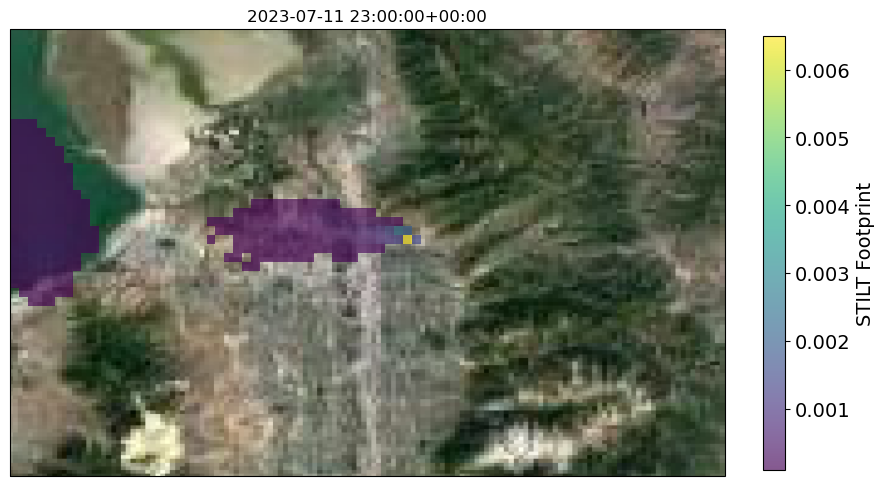

In [46]:
inst_lat = 40.766
inst_lon = -111.847
labsize = 14
zoom = 2
proj = ccrs.PlateCarree()
request = cimgt.GoogleTiles(style='satellite')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
min_foot = 0.0001

#sim_id = 0
for run_time,summed_ds in summed_ds_ts.items():
    extent=[-112.3,-111.5,40.5,41.0]

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    ax.add_image(request,int(scale))
    foot = summed_ds['foot_x_wgt']
    masked_foot = foot.where(foot>min_foot)
    footplot = masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)

    plt.title(run_time)
    plt.gcf().autofmt_xdate()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


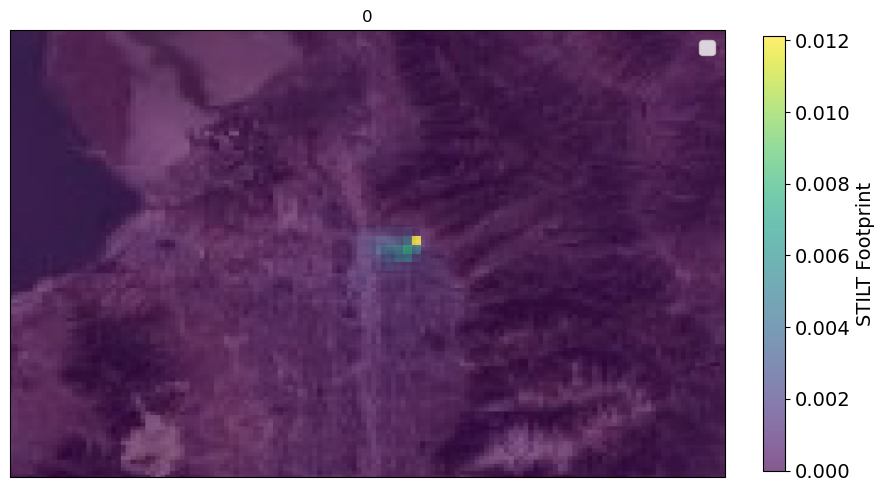

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


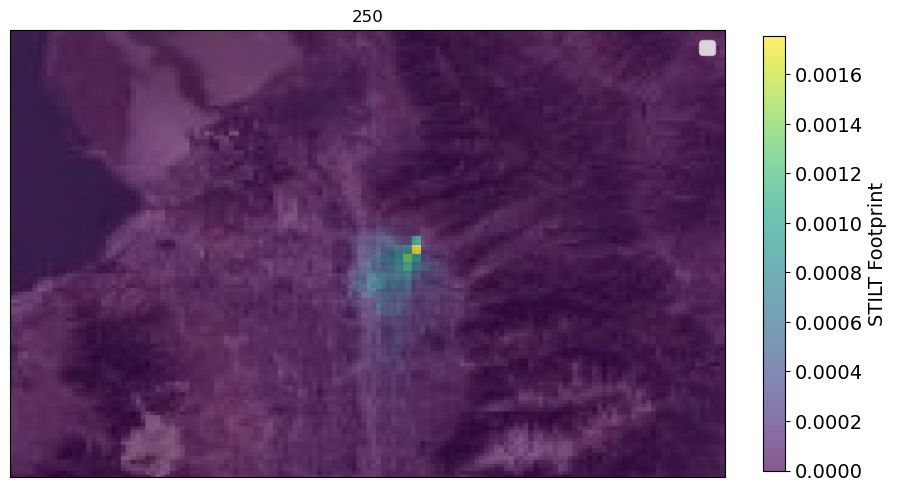

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


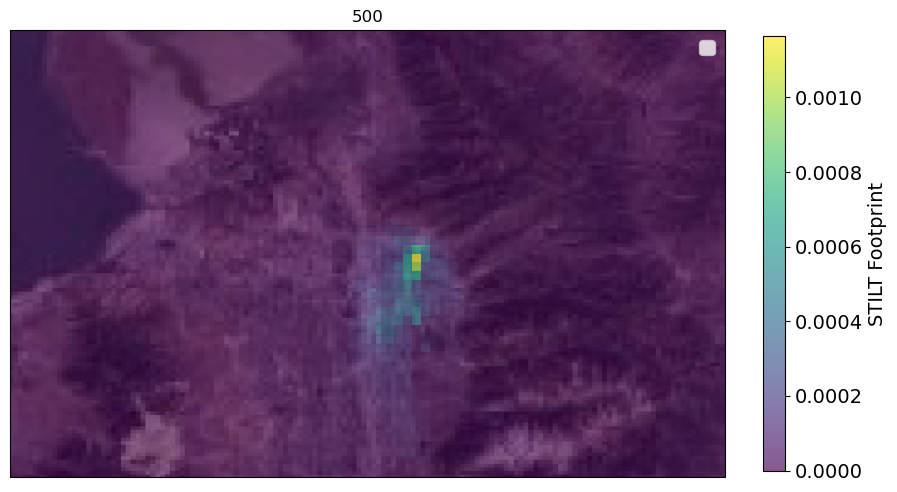

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


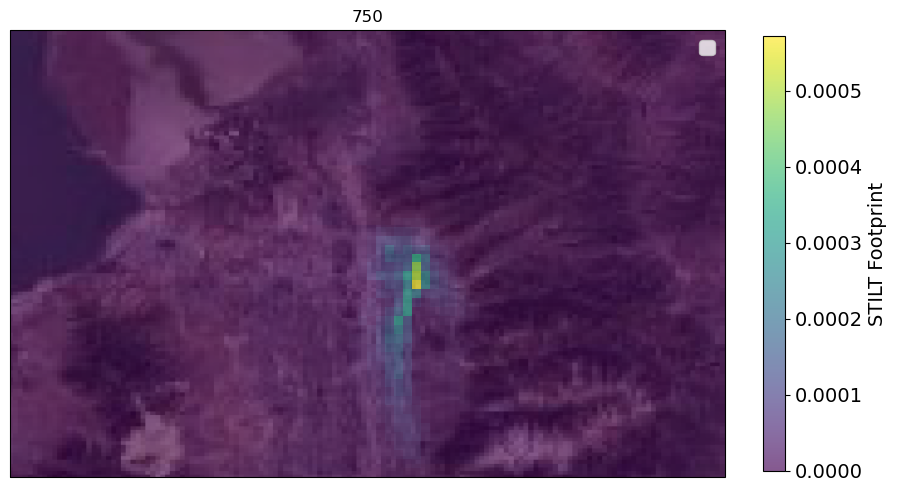

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


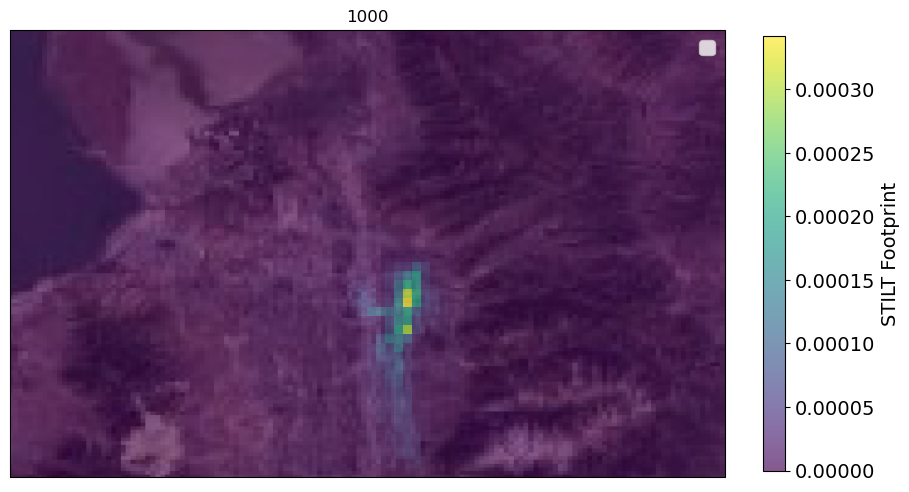

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


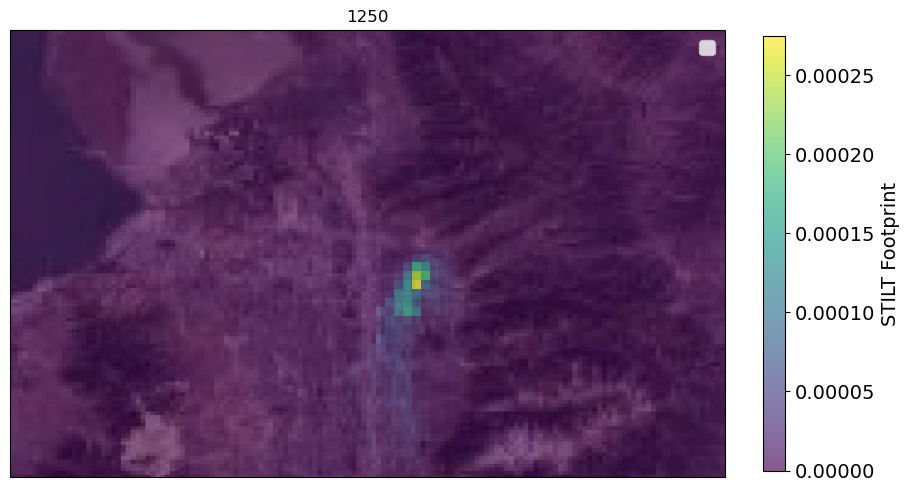

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


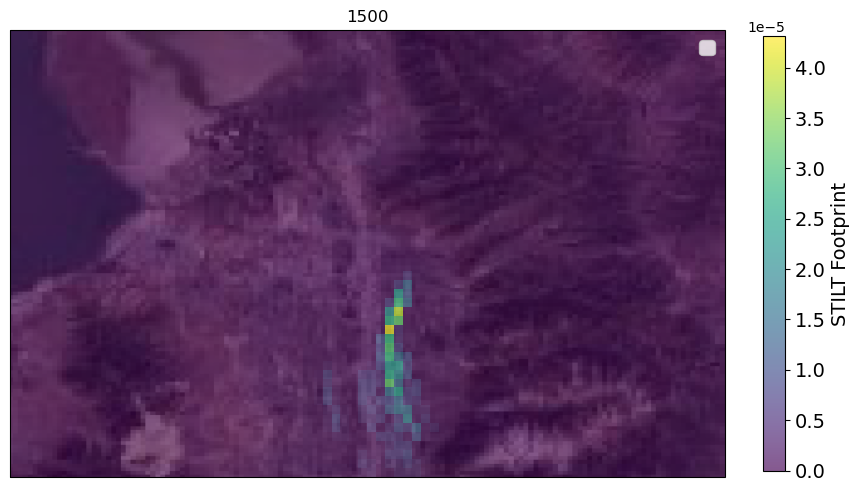

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


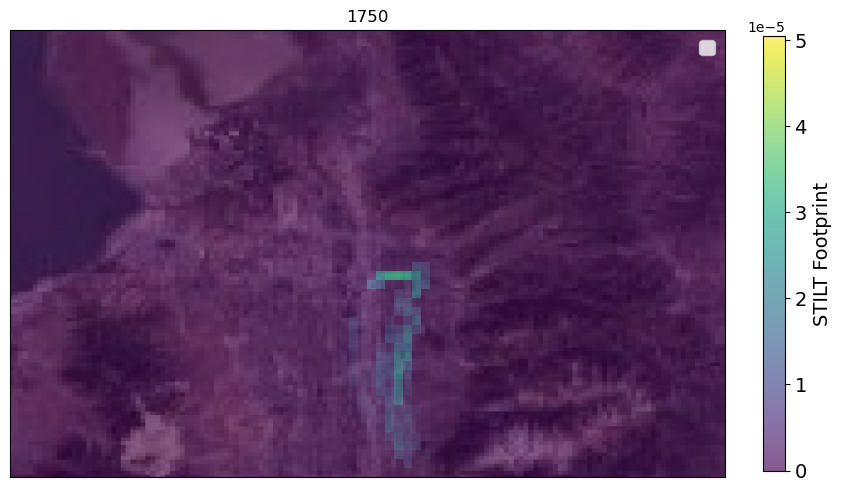

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


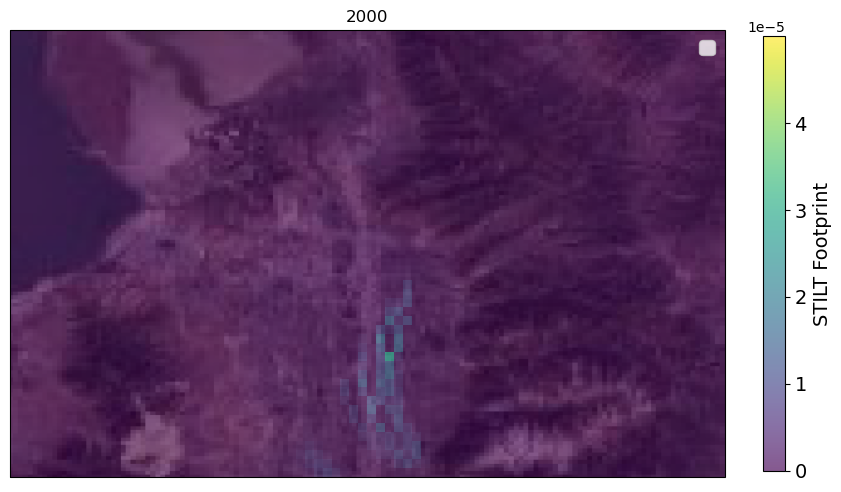

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [17]:
inst_lat = 40.766
inst_lon = -111.847
labsize = 14
zoom = 2
proj = ccrs.PlateCarree()


#sim_id = 0
for level in combined_ds[sim_id_mapdict['new_dim_name']].values:
    extent=[-112.3,-111.5,40.5,41.0]

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    request = cimgt.GoogleTiles(style='satellite')
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    ax.add_image(request,int(scale))
    footplot = combined_ds.sel({sim_id_mapdict['new_dim_name']:level})['foot_x_wgt'].plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)


    ax.legend(fontsize=labsize,loc = 0)
    plt.title(level)
    plt.gcf().autofmt_xdate()
    plt.show()